In [2]:
!pip install prophet pandas numpy matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 156.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.7 MB/s eta 0:00:00


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn-v0_8')


In [9]:
df = pd.read_csv('/content/Data (1).csv')
df.head()


,sale_date,product_unit_sales,discount_amount (Rs.),mrp_amount (Rs.),product
0,7/30/2016,1469,841262.54,2772121.0,shirt
1,12/24/2016,2668,951832.49,5265812.0,shirt
2,9/5/2016,595,20077.38,1112225.0,shirt
3,9/8/2016,655,127786.36,1238535.0,shirt
4,7/17/2016,2561,1385088.70,4822249.0,shirt


In [10]:
df['sale_date'] = pd.to_datetime(df['sale_date'])
df = df.sort_values('sale_date')

# Use single product to avoid mixing behaviors
product_name = df['product'].unique()[0]
df = df[df['product'] == product_name]

df.head()


,sale_date,product_unit_sales,discount_amount (Rs.),mrp_amount (Rs.),product
225,2016-01-01,831,209547.22,1476259.0,shirt
164,2016-01-02,1209,398611.22,2140831.0,shirt
209,2016-01-03,1637,556444.28,2943443.0,shirt
160,2016-01-04,665,208259.20,1185095.0,shirt
215,2016-01-05,704,240245.33,1259026.0,shirt


In [11]:
monthly = (
    df
    .set_index('sale_date')
    .resample('M')
    .agg({
        'product_unit_sales': 'sum',
        'discount_amount (Rs.)': 'sum',
        'mrp_amount (Rs.)': 'mean'
    })
    .reset_index()
)

monthly.rename(columns={
    'sale_date': 'ds',
    'product_unit_sales': 'y',
    'discount_amount (Rs.)': 'discount',
    'mrp_amount (Rs.)': 'mrp'
}, inplace=True)

monthly.head()


/tmp/ipython-input-1527668160.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


,ds,y,discount,mrp
0,2016-01-31,37113,13330734.77,2.153003e+06
1,2016-02-29,27909,7344298.30,1.723072e+06
2,2016-03-31,19210,1690486.81,1.108104e+06
3,2016-04-30,24743,2168331.18,1.477148e+06
4,2016-05-31,19991,4656051.01,1.150641e+06


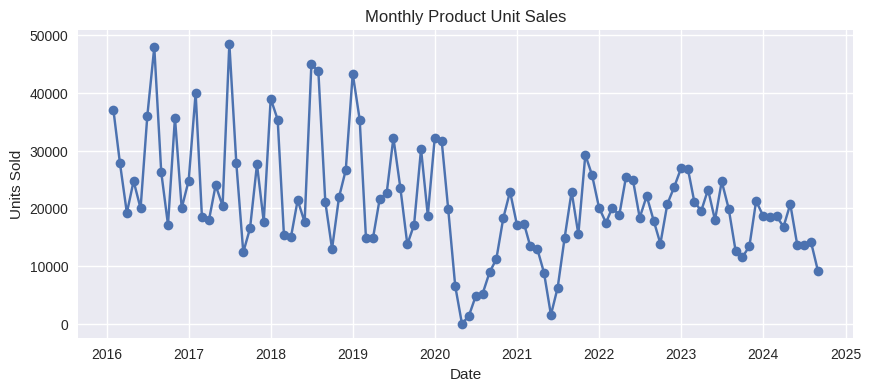

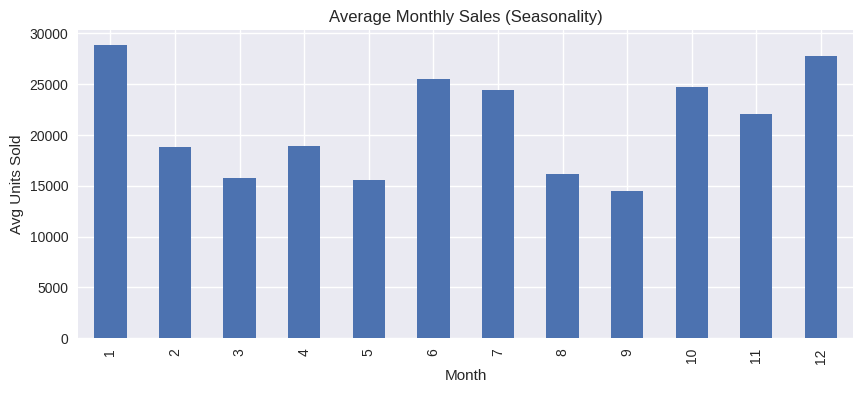

In [12]:
plt.figure(figsize=(10,4))
plt.plot(monthly['ds'], monthly['y'], marker='o')
plt.title('Monthly Product Unit Sales')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.show()

monthly['month'] = monthly['ds'].dt.month
seasonality = monthly.groupby('month')['y'].mean()

plt.figure(figsize=(10,4))
seasonality.plot(kind='bar')
plt.title('Average Monthly Sales (Seasonality)')
plt.xlabel('Month')
plt.ylabel('Avg Units Sold')
plt.show()


In [13]:
def rolling_validation(data, min_train=24, val_window=6):
    for start in range(min_train, len(data) - val_window):
        train = data.iloc[:start].copy()
        val = data.iloc[start:start + val_window].copy()
        yield train, val


In [14]:
def build_prophet_model():
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.3
    )

    # Quarterly seasonality
    model.add_seasonality(
        name='quarterly',
        period=91.25,
        fourier_order=5
    )

    # External regressors
    model.add_regressor('discount')
    model.add_regressor('mrp')

    return model


In [15]:
results = []

for train, val in rolling_validation(monthly):

    # Impute missing 'mrp' values before scaling for both train and val
    # using the mean of the respective split to avoid data leakage.
    if train['mrp'].isnull().any():
        train['mrp'] = train['mrp'].fillna(train['mrp'].mean())
    if val['mrp'].isnull().any():
        val['mrp'] = val['mrp'].fillna(train['mrp'].mean()) # Use train mean for val to avoid leakage

    # Scale regressors using TRAIN only
    scaler = StandardScaler()
    train[['discount','mrp']] = scaler.fit_transform(train[['discount','mrp']])
    val[['discount','mrp']] = scaler.transform(val[['discount','mrp']])

    # Log transform target
    train['y_log'] = np.log1p(train['y'])
    val['y_log'] = np.log1p(val['y'])

    model = build_prophet_model()

    model.fit(
        train[['ds','y_log','discount','mrp']]
        .rename(columns={'y_log':'y'})
    )

    forecast = model.predict(
        val[['ds','discount','mrp']]
    )

    y_pred = np.expm1(forecast['yhat'])
    y_true = val['y'].values

    # Month-on-Month MAPE
    mom_mape = mean_absolute_percentage_error(y_true, y_pred)

    # Overall 6-Month cumulative MAPE
    overall_mape = mean_absolute_percentage_error(
        np.cumsum(y_true),
        np.cumsum(y_pred)
    )

    # Naive baseline
    naive_pred = np.repeat(train['y'].iloc[-1], len(y_true))
    baseline_mape = mean_absolute_percentage_error(y_true, naive_pred)

    results.append({
        'MoM_MAPE_%': mom_mape * 100,
        'Overall_6M_MAPE_%': overall_mape * 100,
        'Baseline_MAPE_%': baseline_mape * 100
    })


INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 24.


In [16]:
results_df = pd.DataFrame(results)

results_df.describe()


,MoM_MAPE_%,Overall_6M_MAPE_%,Baseline_MAPE_%
count,7.400000e+01,7.400000e+01,7.400000e+01
mean,8.976168e+61,4.998771e+61,1.412791e+20
std,7.721591e+62,4.300106e+62,5.184040e+20
min,1.928479e+01,6.366994e+00,1.193782e+01
25%,5.395769e+01,3.785767e+01,2.711630e+01
50%,1.242358e+02,9.601131e+01,3.651721e+01
75%,3.123653e+02,2.619164e+02,8.266243e+01
max,6.642364e+63,3.699091e+63,2.418358e+21


In [17]:
print("MoM MAPE ≤ 15% pass rate:",
      (results_df['MoM_MAPE_%'] <= 15).mean())

print("Overall 6-Month MAPE ≤ 15% pass rate:",
      (results_df['Overall_6M_MAPE_%'] <= 15).mean())


MoM MAPE ≤ 15% pass rate: 0.0
Overall 6-Month MAPE ≤ 15% pass rate: 0.04054054054054054


In [40]:
scaler = StandardScaler()

# Impute missing 'mrp' values in the entire monthly dataframe
if monthly['mrp'].isnull().any():
    monthly['mrp'] = monthly['mrp'].fillna(monthly['mrp'].mean())

monthly[['discount','mrp']] = scaler.fit_transform(
    monthly[['discount','mrp']]
)

monthly['y_log'] = np.log1p(monthly['y'])

final_model = build_prophet_model()

final_model.fit(
    monthly[['ds','y_log','discount','mrp']]
    .rename(columns={'y_log':'y'})
)


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


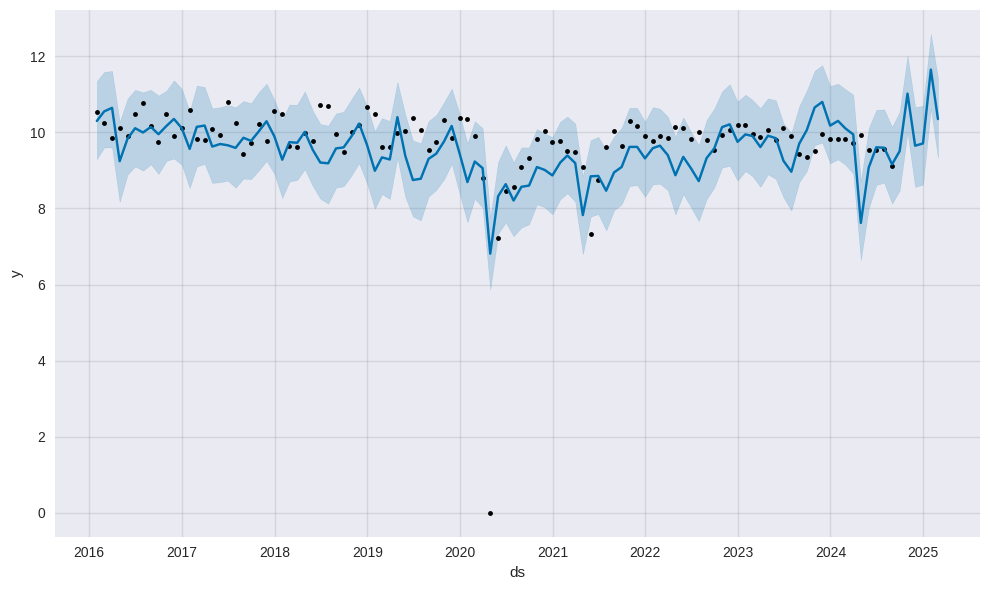

In [36]:
future = final_model.make_future_dataframe(periods=6, freq='M')

future['discount'] = monthly['discount'].iloc[-6:].mean()
future['mrp'] = monthly['mrp'].iloc[-6:].mean()

forecast = final_model.predict(future)
forecast['yhat_final'] = np.expm1(forecast['yhat'])

final_model.plot(forecast)
plt.show()


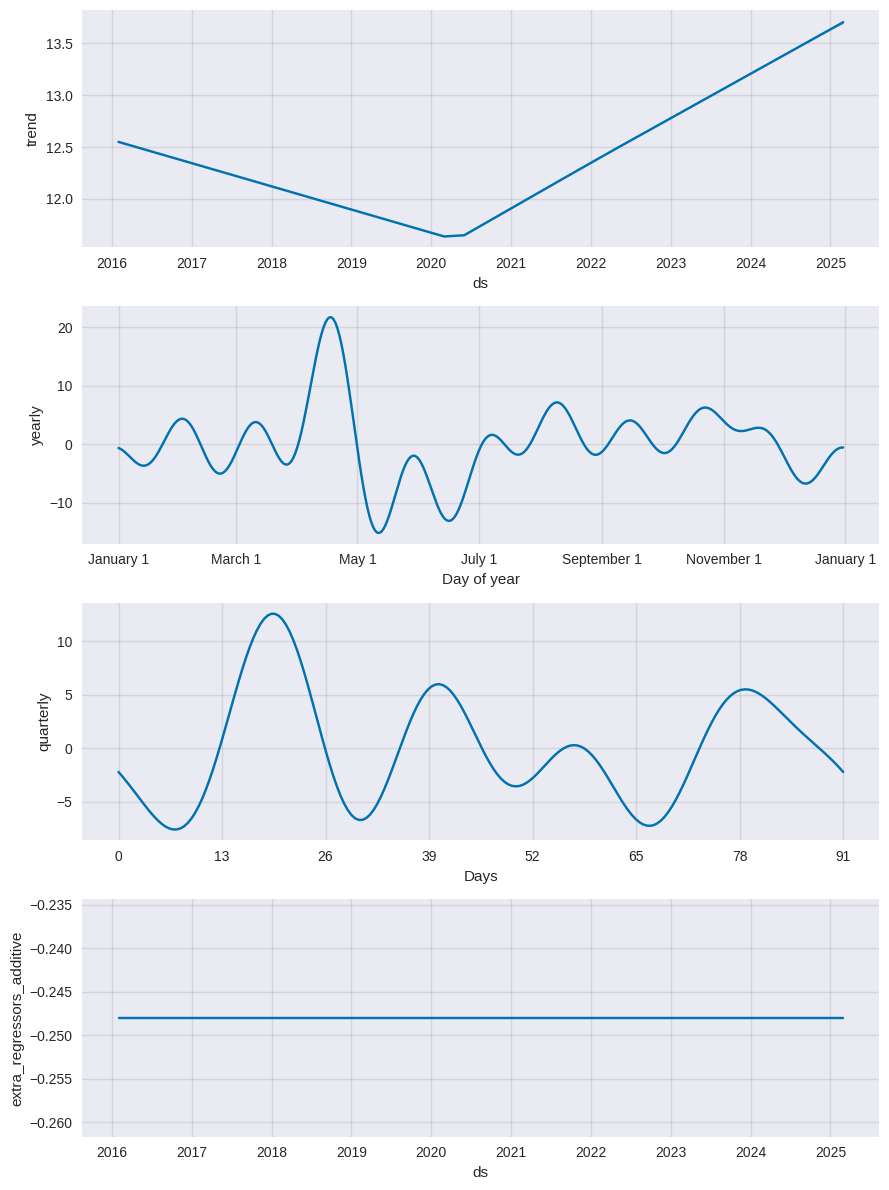

In [37]:
final_model.plot_components(forecast)
plt.show()


In [38]:
forecast[['ds','yhat_final','yhat_lower','yhat_upper']].to_csv(
    'final_sales_forecast.csv',
    index=False
)
